# Treeflow example - carnivores data

Dataset from **Suchard, Marc A., and Andrew Rambaut. "Many-core algorithms for statistical phylogenetics." *Bioinformatics* 25.11 (2009): 1370-1376.**

Sequences accessed from [Beast examples on Github](https://github.com/beast-dev/beast-mcmc/blob/v1.10.4/examples/Benchmarks/benchmark2.xml).

In [1]:
import treeflow

2022-05-08 16:05:03.702803: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-08 16:05:03.702825: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Read input data

In [2]:
tree = treeflow.convert_tree_to_tensor(treeflow.parse_newick("demo-data/carnivores.newick"))
tree.taxon_set

2022-05-08 16:05:07.964339: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-08 16:05:07.964362: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-08 16:05:07.964377: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (CS424460): /proc/driver/nvidia/version does not exist
2022-05-08 16:05:07.964594: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


('Puma_concolor_',
 'Acinonyx_jubatus_',
 'Lynx_canadensis_',
 'Felis_silvestris_',
 'Uncia_uncia_',
 'Panthera_pardus_',
 'Panthera_tigris_',
 'Neofelis_nebulosa_',
 'Herpestes_auropunctatus_',
 'Leptonychotes_weddellii_',
 'Hydrurga_leptonyx_',
 'Ommatophoca_rossii_',
 'Lobodon_carcinophaga_',
 'Mirounga_leonina_',
 'Mirounga_angustirostris_',
 'Monachus_monachus_',
 'Monachus_schauinslandi_',
 'Phoca_fasciata_',
 'Phoca_groenlandica_',
 'Phoca_caspica_',
 'Halichoerus_grypus_',
 'Phoca_sibirica_',
 'Phoca_largha_',
 'Phoca_vitulina_',
 'Phoca_hispida_',
 'Cystophora_cristata_',
 'Erignathus_barbatus_',
 'Arctocephalus_forsteri_',
 'Arctocephalus_australis_',
 'Arctocephalus_townsendi_',
 'Neophoca_cinerea_',
 'Phocarctos_hookeri_',
 'Arctocephalus_pusillus_',
 'Otaria_byronia_',
 'Zalophus_californianus_',
 'Eumetopias_jubatus_',
 'Callorhinus_ursinus_',
 'Odobenus_rosmarus_',
 'Enhydra_lutris_',
 'Lontra_canadensis_',
 'Mustela_vison_',
 'Martes_melampus_',
 'Martes_americana_',
 '

In [3]:
alignment = treeflow.Alignment("demo-data/carnivores.fasta").get_compressed_alignment()
alignment

WeightedAlignment(taxon_count=62, pattern_count=5565)

Calibrations from **Hassanin, Alexandre, et al. "Evolutionary history of Carnivora (Mammalia, Laurasiatheria) inferred from mitochondrial genomes." *PloS one* 16.2 (2021): e0240770.**

In [ ]:
import yaml
with open("demo-data/carnivore-calibrations.yaml") as f:
    calibration_dict = yaml.safe_load(f)
    
calibration_set = treeflow.MRCACalibrationSet(calibration_dict)
calibration_set

## Model specification

### Single kappa parameter across tree

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
from treeflow import float_constant as c
from treeflow.evolution.substitution import HKY, get_transition_probabilities_tree
from treeflow.distributions import DiscretizedDistribution, DiscreteParameterMixture, LeafCTMC, SampleWeighted


site_category_count = 4
pattern_counts = alignment.get_weights_tensor()
subst_model = HKY()

def build_sequence_dist(tree, kappa, frequencies, site_gamma_shape):
    unrooted_tree = tree.get_unrooted_tree()
    site_rate_distribution = DiscretizedDistribution(
        category_count=site_category_count,
        distribution=tfp.distributions.Gamma(concentration=site_gamma_shape, rate=site_gamma_shape),
    )
    transition_probs_tree = get_transition_probabilities_tree(
        unrooted_tree,
        subst_model,
        rate_categories=site_rate_distribution.support,
        frequencies=frequencies,
        kappa=kappa
    )
    return SampleWeighted(
        DiscreteParameterMixture(
            site_rate_distribution,
            LeafCTMC(
                transition_probs_tree,
                tf.expand_dims(frequencies, -2),
            ),
        ),
        sample_shape=alignment.site_count,
        weights=pattern_counts
    )
    

base_model = tfp.distributions.JointDistributionNamed(dict(
    birth_rate=tfp.distributions.LogNormal(c(1.0), c(1.5)),
    tree=lambda birth_rate: treeflow.distributions.Yule(tree.taxon_count, birth_rate, name="tree"),
    kappa=tfp.distributions.LogNormal(c(0.0), c(2.0)),
    site_gamma_shape=tfp.distributions.LogNormal(c(0.0), c(1.0)),
    frequencies=tfp.distributions.Dirichlet(c([2.0, 2.0, 2.0, 2.0])),
    sequences=build_sequence_dist
))
base_model_pinned = base_model.experimental_pin(sequences=alignment.get_encoded_sequence_tensor(tree.taxon_set))
prior_samples = base_model_pinned.sample_unpinned()
prior_samples.keys()

/home/cswa648/dev/treeflow/treeflow/distributions/tree/birthdeath/birth_death_contemporary_sampling.py:69: UserWarning: Dummy sampling
  warnings.warn("Dummy sampling")
/home/cswa648/dev/treeflow/treeflow/tf_util/attrs.py:7: UserWarning: Temporary hotfix
  warnings.warn("Temporary hotfix")


/home/cswa648/dev/treeflow/treeflow/distributions/leaf_ctmc.py:62: UserWarning: Dummy sampling of alignment
  warnings.warn("Dummy sampling of alignment")


dict_keys(['birth_rate', 'tree', 'site_gamma_shape', 'kappa', 'frequencies'])

/home/cswa648/dev/treeflow/treeflow/tf_util/attrs.py:7: UserWarning: Temporary hotfix
  warnings.warn("Temporary hotfix")


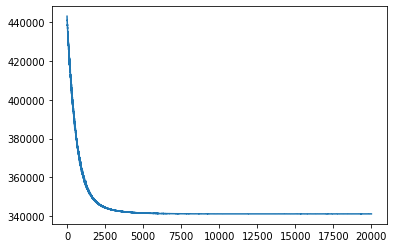

In [8]:
from treeflow.vi import fit_fixed_topology_variational_approximation
import matplotlib.pyplot as plt

optimizer = tf.optimizers.Adam()
num_steps= 20000
base_approx, base_loss = fit_fixed_topology_variational_approximation(
    base_model_pinned,
    topologies=dict(tree=tree.topology),
    optimizer=optimizer,
    num_steps=num_steps,
    trace_fn= lambda x: x.loss
)
plt.plot(base_loss)

/home/cswa648/dev/treeflow/treeflow/tf_util/attrs.py:7: UserWarning: Temporary hotfix
  warnings.warn("Temporary hotfix")
/home/cswa648/dev/treeflow/treeflow/distributions/tree/birthdeath/birth_death_contemporary_sampling.py:69: UserWarning: Dummy sampling
  warnings.warn("Dummy sampling")


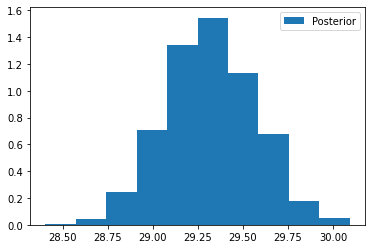

In [10]:
n_samples = 1000
base_samples = base_approx.sample(n_samples)
prior_samples = base_model_pinned.sample_unpinned(n_samples)

plt.hist(base_samples["kappa"].numpy(), label="Posterior", density=True)
plt.legend()

(array([  9.,  23.,  93., 171., 241., 204., 160.,  77.,  18.,   4.]),
 array([1.16578352, 1.16972377, 1.17366402, 1.17760428, 1.18154453,
        1.18548478, 1.18942503, 1.19336528, 1.19730553, 1.20124578,
        1.20518603]),
 <BarContainer object of 10 artists>)

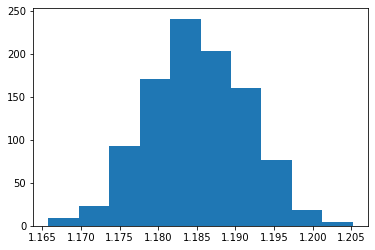

In [17]:
plt.hist(base_samples["tree"].node_heights[:, -1].numpy())

### Per site kappa parameter

In [5]:
def build_sequence_dist_alt(tree, kappa, frequencies, site_gamma_shape):
    # kappa has shape (..., n_branches)
    unrooted_tree = tree.get_unrooted_tree()
    site_rate_distribution = DiscretizedDistribution(
        category_count=site_category_count,
        distribution=tfp.distributions.Gamma(concentration=site_gamma_shape, rate=site_gamma_shape),
    )
    frequencies_b = tf.broadcast_to(tf.expand_dims(frequencies, -2), kappa.shape + (4,))
    transition_probs_tree = get_transition_probabilities_tree(
        unrooted_tree,
        subst_model,
        rate_categories=site_rate_distribution.support,
        frequencies=frequencies_b,
        kappa=kappa,
        inner_batch_rank=1,
        batch_rank=-1 # Don't add a batch dimension for branches
    )
    return SampleWeighted(
        DiscreteParameterMixture(
            site_rate_distribution,
            LeafCTMC(
                transition_probs_tree,
                tf.expand_dims(frequencies, -2),
            ),
        ),
        sample_shape=alignment.site_count,
        weights=pattern_counts
    )
alt_model = tfp.distributions.JointDistributionNamed(dict(
    birth_rate=tfp.distributions.LogNormal(c(1.0), c(1.5)),
    tree=lambda birth_rate: treeflow.distributions.Yule(tree.taxon_count, birth_rate, name="tree"),
    kappa=tfp.distributions.Sample(tfp.distributions.LogNormal(c(0.0), c(2.0)), tree.branch_lengths.shape),
    site_gamma_shape=tfp.distributions.LogNormal(c(0.0), c(1.0)),
    frequencies=tfp.distributions.Dirichlet(c([2.0, 2.0, 2.0, 2.0])),
    sequences=build_sequence_dist_alt
))
alt_model_pinned = alt_model.experimental_pin(sequences=alignment.get_encoded_sequence_tensor(tree.taxon_set))
prior_samples = alt_model_pinned.sample_unpinned()
prior_samples.keys()

dict_keys(['birth_rate', 'tree', 'site_gamma_shape', 'kappa', 'frequencies'])

/home/cswa648/dev/treeflow/treeflow/tf_util/attrs.py:7: UserWarning: Temporary hotfix
  warnings.warn("Temporary hotfix")


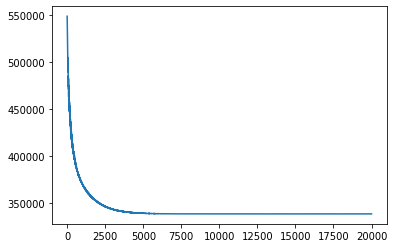

In [9]:
alt_approx, alt_loss = fit_fixed_topology_variational_approximation(
    alt_model_pinned,
    topologies=dict(tree=tree.topology),
    optimizer=optimizer,
    num_steps=num_steps,
    trace_fn= lambda x: x.loss
)
plt.plot(alt_loss)

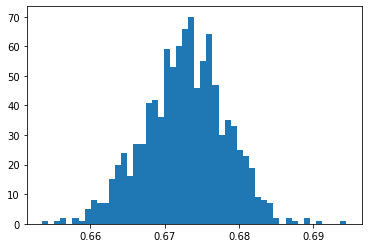

In [18]:
alt_samples = alt_approx.sample(n_samples)
plt.hist(alt_samples["tree"].node_heights[:, -1].numpy(), bins=50);

In [22]:
[tf.reduce_mean(x[-100:]) for x in [base_loss, alt_loss]]

[<tf.Tensor: shape=(), dtype=float64, numpy=341175.8453315826>,
 <tf.Tensor: shape=(), dtype=float64, numpy=338656.21174349566>]

In [26]:
kappa_df

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,120,121
0,78.811041,37.386057,68.721898,58.955882,29.502499,102.260189,85.529051,54.088627,11.394314,66.248865,...,89.293718,41.503416,57.765521,23.333823,6.293551,0.362415,18.876719,10.589676,5.615153,0.056232
1,51.763252,34.556218,90.696012,50.841984,30.488527,95.069485,84.064802,56.936612,11.150776,62.896212,...,75.482491,59.214882,57.974597,28.941629,6.702225,0.039279,17.513188,8.943786,5.468083,1.972970
2,69.255326,37.719161,61.838235,45.729102,31.397321,106.404460,80.943702,57.373155,11.009515,62.857296,...,89.170940,131.629398,54.480005,21.852805,7.507570,0.040216,19.375074,8.562980,5.695907,0.086434
3,73.573702,51.071271,66.608769,48.700592,32.013484,91.338491,99.950329,69.173420,11.837545,60.545419,...,91.440115,47.122370,54.128676,26.997150,5.877806,0.210873,17.764069,10.891308,6.592884,0.043851
4,60.493262,45.909051,72.109916,52.248126,24.597699,89.894737,81.149118,58.579209,11.838689,61.200926,...,65.986129,113.327565,63.983616,44.054797,6.869326,0.017832,15.957542,11.452116,5.647730,0.025072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,70.267946,44.195573,73.729464,45.513567,21.678108,119.430769,81.666347,50.603551,12.002623,60.707137,...,76.981147,186.873177,63.004395,27.402759,6.035066,0.093624,16.491849,9.041719,5.451131,0.230982
996,88.087614,44.651708,80.412560,57.055892,31.792892,87.210806,78.392499,57.412184,11.736553,75.964214,...,76.128017,39.750717,52.526218,21.958476,6.111427,0.035128,18.963710,11.655643,5.753183,0.483474
997,57.083502,45.356179,75.147886,52.846300,25.693784,161.802517,87.403061,57.006720,11.531319,40.139017,...,94.775530,69.935422,54.113033,23.472007,6.138370,0.038085,17.340087,9.677898,5.772434,7.421441
998,55.980327,35.176685,64.987939,45.578181,32.705231,122.395963,93.787405,71.332101,12.266570,55.297441,...,103.302185,613.085776,60.131477,32.717925,6.609118,1.486897,17.281910,10.094495,5.774682,0.087868


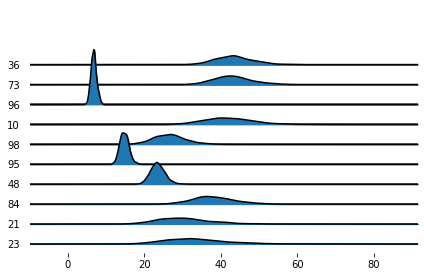

In [33]:
import joypy
import numpy as np
import pandas as pd

kappa_df = pd.DataFrame(alt_samples["kappa"].numpy())
n_columns = 10
columns = np.random.choice(kappa_df.columns, n_columns, replace=False)
joypy.joyplot(kappa_df[columns]);

## Results visualisation


* Use existing tree viz tools